<a href="https://colab.research.google.com/github/tomkark/SOT_ViT/blob/main/TrainTest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Training a Compact Vision Transformer


The next colab is based on the one published by the developers of the cct&cvt from SHI LABS
 https://medium.com/pytorch/training-compact-transformers-from-scratch-in-30-minutes-with-pytorch-ff5c21668ed5

### CIFAR-10

We're going to use ``torchvision``'s CIFAR-10 dataset, which will automatically download it as well.

Its classes are: ‘airplane’, ‘automobile’, ‘bird’, ‘cat’, ‘deer’,
‘dog’, ‘frog’, ‘horse’, ‘ship’, ‘truck’. The images in CIFAR-10 are of
size 3x32x32, i.e. 3-channel color images of 32x32 pixels in size.


### Training an image classifier

We will do the following steps in order:

1. Download CIFAR-10 and load it
2. Clone the Compact Transformers repository from GitHub
3. Train the network on CIFAR-10
4. Load the trained checkpoint
5. Test the network on the test data

## 1. Loading the prerequisites

We need to import some basic requirements (PyTorch, Torchvision, and matplotlib).

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt


cifar10_mean, cifar10_std = [0.4914, 0.4822, 0.4465], [0.2470, 0.2435, 0.2616]
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize(cifar10_mean, cifar10_std)])


classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

This function will plot images, their labels and the predicted labels (if specified). We'll use it as we go through.
----It will desplay (at the moment) the labels and predictions correctly only when batch size == 4----

In [2]:
def imshow(images, labels, predicted_labels=None):
    # Using torchvision to make a grid of the images
    img = torchvision.utils.make_grid(images)

    # Inverting the normalization
    img = img.permute(1, 2, 0).mul(torch.tensor(cifar10_std))
    img += torch.tensor(cifar10_mean)

    # Plotting the grid
    fig, ax = plt.subplots(figsize=(6, 24))
    plt.imshow(img)

    if predicted_labels is not None:
        # Outputing the predicted labels
        ax.set_xlabel('Predicted labels', fontsize=18, labelpad=12)
        ax.set_xticks(torch.arange(len(images)) * 35 + 20)
        ax.set_xticklabels([classes[predicted_labels[j]] 
                            for j in range(len(images))], fontsize=14)
    
    # Outputing the ground truth labels
    if(len(images)<9):
      gax = ax.secondary_xaxis('top')
      gax.set_xlabel('Ground truth', fontsize=18, labelpad=12)
      gax.set_xticks(torch.arange(len(images)) * 35 + 20)
      gax.set_xticklabels([classes[labels[j]] 
                          for j in range(len(images))], fontsize=14)
    plt.show()

## 2. Loading and normalizing CIFAR10
Using ``torchvision``, it’s extremely easy to load CIFAR10.

In [3]:
batch_size = 4 #we train on 128 but for the display the default is 4

trainset = torchvision.datasets.CIFAR10(root='./cifar10', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./cifar10', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=True, num_workers=2)

dataiter = iter(trainloader)
test_dataiter = iter(testloader)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./cifar10/cifar-10-python.tar.gz to ./cifar10
Files already downloaded and verified


**Let's view some of the training images, for fun.** \\
Run this cell to see outputs. \\
You can run this cell multiple times.
Each run should return different images

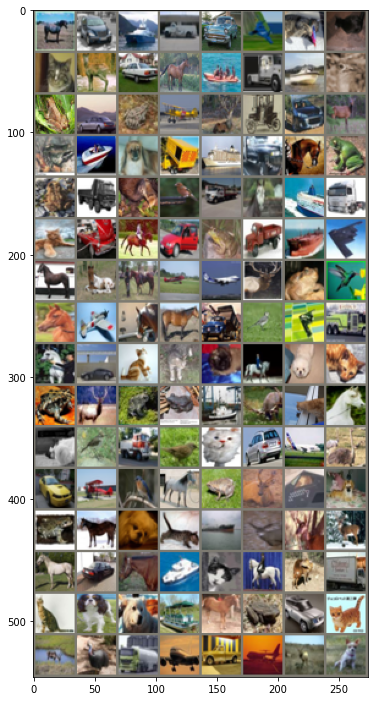

In [4]:
images, labels = dataiter.next()
imshow(images, labels)

## 3. Train CCT on CIFAR-10
We're going to clone the repository first.


In [5]:
from os.path import exists
%cd /content
if not exists("SOT_ViT"):
  !git clone https://github.com/tomkark/SOT_ViT.git
  %cd SOT_ViT

else:
  %cd SOT_ViT
  !git pull


/content
Cloning into 'SOT_ViT'...
remote: Enumerating objects: 199, done.
remote: Counting objects: 100% (199/199), done.
remote: Compressing objects: 100% (147/147), done.
remote: Total 199 (delta 116), reused 115 (delta 51), pack-reused 0
Receiving objects: 100% (199/199), 1.29 MiB | 2.08 MiB/s, done.
Resolving deltas: 100% (116/116), done.
/content/SOT_ViT


We'll train $CCT-2/3\times2$ from the paper ( $\approx 280$ K parameters) for $30$ epochs. It should take around 10 minutes (may vary depending on which GPU Colab assigns to you).

Training is fairly simple,
we'll just run `main.py` with the the appropriate args.
The script will train and logs performance and time.
ot is the regularization parameter for the Sinkhorn algorithm.

In [17]:
!python main.py \
       --ot=0.1 \
       --model cct_2 \
       --conv-size 3 \
       --conv-layers 2 \
       --print-freq -1 \
       --epochs 30 \
       --workers 2 \
       ../cifar10

GPU (CUDA) Status: True
Files already downloaded and verified
Beginning training 0.1
Exception ignored in: <function _releaseLock at 0x7f338a071830>
Traceback (most recent call last):
  File "/usr/lib/python3.7/logging/__init__.py", line 221, in _releaseLock
    def _releaseLock():
KeyboardInterrupt
^C


## 4. Evaluation
Now we're going to load our trained transformer from file. \\
The script stores checkpoints in `checkpoint.pth`.

In [8]:
from src.cct import cct_2

transformer = cct_2(img_size=32,
                    num_classes=10,
                    positional_embedding='learnable',
                    n_conv_layers=2,
                    kernel_size=3)

transformer.load_state_dict(torch.load('checkpoint.pth'))

<All keys matched successfully>

**Okay, now let us see what the transformer thinks these examples above are:** \\
Run this cell to see outputs. \\
You can run this cell multiple times.
Each run should return different images

In [9]:
#The following lines can be used to "inject" specific images to the test batch 
# and inspect the heat_map in "plot" mode
# images, labels = test_dataiter.next()
# torch.save(images[0], "exampleImage.pt")
# torch.save(images[1], "exampleImage1.pt")
# torch.save(labels[0], "labels.pt")
# torch.save(labels[1], "labels1.pt")
# images[0] = torch.load("exampleImage.pt")
# images[1] = torch.load("exampleImage1.pt")
# labels[0] = torch.load("labels.pt")
# labels[1] = torch.load("labels1.pt")
#------
#We saw above the results during training, now we will iterate over almost all of the 10000 test images
#and print the accuracy percentage:
result = 0
iterations = 10000//batch_size
for i in range(iterations):
  images, labels = test_dataiter.next()
  _, predicted = torch.max(transformer(images), 1)
  result += torch.sum(labels == predicted)

result = "{:.2f}".format((100*result)/(batch_size*iterations))
print("The success rate of the model over the test set (10000 images) is: ")
print(result)

# imshow(images, labels, predicted)

The success rate of the model over the test set (1000 images) is: 
32.12
